In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [58]:
class Vehicle:
    def __init__(self):
        # Throttle to engine torque equation constants
        self.a_0 = 400
        self.a_1 = 0.1
        self.a_2 = -0.0002

        # Gear ratio, effective radius and engine inertia
        self.gear_ratio = 0.35
        self.eff_radius = 0.3
        self.engine_inertia = 10
        self.mass = 2000
        self.g_acc = 9.81

        #aero and friction coefficients
        self.drag_coeff = 1.36
        self.friction_coeff = 0.01
        
        # Tire force
        self.tire_stiffness = 10000
        self.tire_force_max = 10000

        # misc info
        self.initial_pos = 0
        self.velocity = 5 #m/s
        self.acc = 0
        self.engine_angular_speed = 100 #rad/s
        self.engine_angular_acc = 0
        self.sampling_time = 0.01 #s
        self.slip_ratio = 0
        self.traction_force=0
    
    def reset(self):
        self.initial_pos = 0
        self.velocity = 5 #m/s
        self.acc = 0 #m/s²
        self.engine_angular_speed = 100 #rad/s
        self.engine_angular_acc = 0
        self.traction_force=0

    def step(self, throttle, alpha):
        engine_torque = throttle*(self.a_0 + self.a_1*self.engine_angular_speed + self.a_2*self.engine_angular_speed**2)
        
        aero_res = self.drag_coeff*self.velocity**2
        gradient_res = self.mass * self.g_acc * np.sin(alpha)
        total_res = aero_res + gradient_res + self.friction_coeff*self.velocity
        
        self.engine_angular_acc = (engine_torque-(self.gear_ratio*self.eff_radius*total_res))/self.engine_inertia

        wheel_speed = self.gear_ratio*self.engine_angular_speed
        self.slip_ratio = (wheel_speed*self.eff_radius - self.velocity)/self.velocity
        self.traction_force = self.tire_stiffness*self.slip_ratio if abs(self.slip_ratio)<1 else self.tire_force_max
        self.acc = (self.traction_force-total_res)/self.mass
        
        self.velocity += self.acc*self.sampling_time
        self.initial_pos += self.velocity*self.sampling_time - (0.5*self.acc*self.sampling_time**2)
        self.engine_angular_speed += self.engine_angular_acc*self.sampling_time

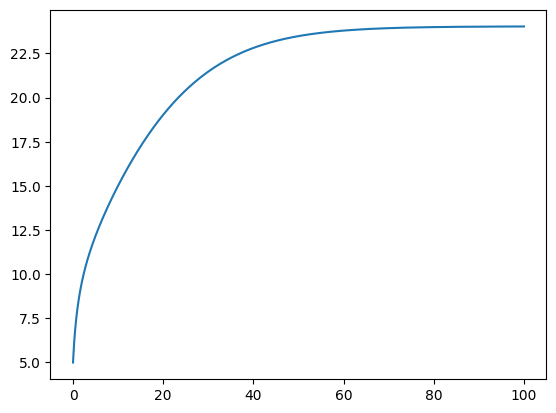

In [63]:
time_end = 100
model = Vehicle()

t_data = np.arange(0,time_end,model.sampling_time)
v_data = np.zeros_like(t_data)
s_data = np.zeros_like(t_data)
fx_data = np.zeros_like(t_data)

# throttle percentage between 0 and 1
throttle = 0.2

# incline angle (in radians)
alpha = 0

for i in range(t_data.shape[0]):
    v_data[i] = model.velocity
    s_data[i] = model.slip_ratio*100
    fx_data[i] = model.traction_force
    #if t_data[i]%5==0:
        #print(s_data[i], '||', t_data[i], '||', v_data[i],  '||', throttle)
    model.step(throttle, alpha)
    
plt.plot(t_data, v_data)
#plt.plot(t_data, s_data)
plt.show()

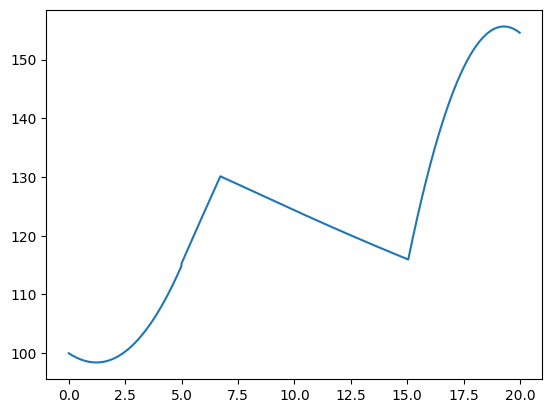

In [88]:
time_end=20
model.reset()
t_data = np.arange(0,time_end, model.sampling_time)
pos_data = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
grad_data = np.zeros_like(t_data)
engine_speed_data = np.zeros_like(t_data)

throttle = 0.2

def gradient(pos):
    if pos < 60:
        return np.arctan(3/60)
    elif pos < 150:
        return np.arctan(9/90)
    else:
        return 0
    
for i in range(t_data.shape[0]):
    if t_data[i]<5:
        model.step(((0.5-0.2)/5)*t_data[i] + 0.2, gradient(model.initial_pos))
        
    elif 5<t_data[i]<15:
        model.step(throttle+0.3, gradient(model.initial_pos))
    
    else:
        model.step((-0.5/5)*(t_data[i]-20), gradient(model.initial_pos))
    
    grad_data[i] = gradient(model.initial_pos)
    pos_data[i] = model.initial_pos
    v_data[i] = model.velocity
    engine_speed_data[i] = model.engine_angular_speed


plt.plot(t_data, engine_speed_data)
plt.show()